In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['targets']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_b25_targets_t1_native_k5_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 1576)
(631390, 1)
validation
(74368, 1576)
(74368, 1)
test
(85358, 1576)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1576)]            0         


 dense (Dense)               (None, 1024)              1614848   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 2304001 (8.79 MB)


Trainable params: 2304001 (8.79 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:43 - loss: 0.0133 - STD: 9.0945e-05 - MAE: 0.0644

 3/64 [>.............................] - ETA: 2s - loss: 0.0204 - STD: 2.5746e-04 - MAE: 0.1058  

 5/64 [=>............................] - ETA: 2s - loss: 0.0209 - STD: 3.6981e-04 - MAE: 0.1017

 7/64 [==>...........................] - ETA: 2s - loss: 0.0210 - STD: 3.7244e-04 - MAE: 0.1002

 9/64 [===>..........................] - ETA: 2s - loss: 0.0195 - STD: 3.5701e-04 - MAE: 0.0923

11/64 [====>.........................] - ETA: 1s - loss: 0.0184 - STD: 3.4647e-04 - MAE: 0.0924

13/64 [=====>........................] - ETA: 1s - loss: 0.0182 - STD: 3.4214e-04 - MAE: 0.0952

15/64 [======>.......................] - ETA: 1s - loss: 0.0176 - STD: 3.3937e-04 - MAE: 0.0940

17/64 [======>.......................] - ETA: 1s - loss: 0.0170 - STD: 3.3467e-04 - MAE: 0.0903

19/64 [=======>......................] - ETA: 1s - loss: 0.0167 - STD: 3.2974e-04 - MAE: 0.0872

21/64 [========>.....................] - ETA: 1s - loss: 0.0165 - STD: 3.2626e-04 - MAE: 0.0847

23/64 [=========>....................] - ETA: 1s - loss: 0.0161 - STD: 3.2558e-04 - MAE: 0.0828

25/64 [==========>...................] - ETA: 1s - loss: 0.0159 - STD: 3.2764e-04 - MAE: 0.0822

27/64 [===========>..................] - ETA: 1s - loss: 0.0157 - STD: 3.3105e-04 - MAE: 0.0825

29/64 [============>.................] - ETA: 1s - loss: 0.0155 - STD: 3.3529e-04 - MAE: 0.0826

31/64 [=============>................] - ETA: 1s - loss: 0.0153 - STD: 3.3918e-04 - MAE: 0.0820

33/64 [==============>...............] - ETA: 1s - loss: 0.0152 - STD: 3.4296e-04 - MAE: 0.0810

35/64 [===============>..............] - ETA: 1s - loss: 0.0151 - STD: 3.4703e-04 - MAE: 0.0799

37/64 [================>.............] - ETA: 1s - loss: 0.0150 - STD: 3.5228e-04 - MAE: 0.0791

39/64 [=================>............] - ETA: 0s - loss: 0.0148 - STD: 3.5932e-04 - MAE: 0.0786

41/64 [==================>...........] - ETA: 0s - loss: 0.0147 - STD: 3.6783e-04 - MAE: 0.0784

43/64 [===================>..........] - ETA: 0s - loss: 0.0146 - STD: 3.7736e-04 - MAE: 0.0782

45/64 [====================>.........] - ETA: 0s - loss: 0.0145 - STD: 3.8800e-04 - MAE: 0.0780

47/64 [=====================>........] - ETA: 0s - loss: 0.0144 - STD: 3.9909e-04 - MAE: 0.0776

49/64 [=====================>........] - ETA: 0s - loss: 0.0144 - STD: 4.1120e-04 - MAE: 0.0771

51/64 [======================>.......] - ETA: 0s - loss: 0.0143 - STD: 4.2476e-04 - MAE: 0.0766

53/64 [=======================>......] - ETA: 0s - loss: 0.0142 - STD: 4.3994e-04 - MAE: 0.0763

55/64 [========================>.....] - ETA: 0s - loss: 0.0142 - STD: 4.5791e-04 - MAE: 0.0762

57/64 [=========================>....] - ETA: 0s - loss: 0.0141 - STD: 4.7778e-04 - MAE: 0.0760

59/64 [==========================>...] - ETA: 0s - loss: 0.0141 - STD: 4.9959e-04 - MAE: 0.0759

61/64 [===========================>..] - ETA: 0s - loss: 0.0140 - STD: 5.2356e-04 - MAE: 0.0756

63/64 [============================>.] - ETA: 0s - loss: 0.0140 - STD: 5.5020e-04 - MAE: 0.0754

64/64 [==============================] - 6s 62ms/step - loss: 0.0140 - STD: 5.6483e-04 - MAE: 0.0753 - val_loss: 0.0165 - val_STD: 0.0013 - val_MAE: 0.0779


Epoch 2/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0127 - STD: 0.0016 - MAE: 0.0693

 3/64 [>.............................] - ETA: 2s - loss: 0.0123 - STD: 0.0017 - MAE: 0.0698

 5/64 [=>............................] - ETA: 2s - loss: 0.0121 - STD: 0.0018 - MAE: 0.0700

 7/64 [==>...........................] - ETA: 2s - loss: 0.0122 - STD: 0.0019 - MAE: 0.0700

 9/64 [===>..........................] - ETA: 2s - loss: 0.0122 - STD: 0.0020 - MAE: 0.0695

11/64 [====>.........................] - ETA: 1s - loss: 0.0122 - STD: 0.0022 - MAE: 0.0691

13/64 [=====>........................] - ETA: 1s - loss: 0.0122 - STD: 0.0023 - MAE: 0.0689

16/64 [======>.......................] - ETA: 1s - loss: 0.0122 - STD: 0.0026 - MAE: 0.0690

18/64 [=======>......................] - ETA: 1s - loss: 0.0122 - STD: 0.0029 - MAE: 0.0691

20/64 [========>.....................] - ETA: 1s - loss: 0.0121 - STD: 0.0032 - MAE: 0.0690

22/64 [=========>....................] - ETA: 1s - loss: 0.0121 - STD: 0.0035 - MAE: 0.0687

24/64 [==========>...................] - ETA: 1s - loss: 0.0120 - STD: 0.0038 - MAE: 0.0685

26/64 [===========>..................] - ETA: 1s - loss: 0.0120 - STD: 0.0043 - MAE: 0.0683

28/64 [============>.................] - ETA: 1s - loss: 0.0119 - STD: 0.0048 - MAE: 0.0681

30/64 [=============>................] - ETA: 1s - loss: 0.0118 - STD: 0.0054 - MAE: 0.0677

32/64 [==============>...............] - ETA: 1s - loss: 0.0116 - STD: 0.0062 - MAE: 0.0673

34/64 [==============>...............] - ETA: 1s - loss: 0.0115 - STD: 0.0072 - MAE: 0.0668

36/64 [===============>..............] - ETA: 1s - loss: 0.0113 - STD: 0.0083 - MAE: 0.0662

38/64 [================>.............] - ETA: 0s - loss: 0.0111 - STD: 0.0098 - MAE: 0.0654

40/64 [=================>............] - ETA: 0s - loss: 0.0109 - STD: 0.0115 - MAE: 0.0646

42/64 [==================>...........] - ETA: 0s - loss: 0.0107 - STD: 0.0136 - MAE: 0.0638

44/64 [===================>..........] - ETA: 0s - loss: 0.0104 - STD: 0.0161 - MAE: 0.0629

46/64 [====================>.........] - ETA: 0s - loss: 0.0102 - STD: 0.0189 - MAE: 0.0620

48/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 0.0219 - MAE: 0.0612

50/64 [======================>.......] - ETA: 0s - loss: 0.0097 - STD: 0.0250 - MAE: 0.0604

52/64 [=======================>......] - ETA: 0s - loss: 0.0094 - STD: 0.0277 - MAE: 0.0597

54/64 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 0.0301 - MAE: 0.0589

56/64 [=========================>....] - ETA: 0s - loss: 0.0090 - STD: 0.0322 - MAE: 0.0581

58/64 [==========================>...] - ETA: 0s - loss: 0.0088 - STD: 0.0342 - MAE: 0.0574

60/64 [===========================>..] - ETA: 0s - loss: 0.0086 - STD: 0.0362 - MAE: 0.0567

62/64 [============================>.] - ETA: 0s - loss: 0.0085 - STD: 0.0383 - MAE: 0.0561

64/64 [==============================] - ETA: 0s - loss: 0.0083 - STD: 0.0402 - MAE: 0.0554

64/64 [==============================] - 3s 42ms/step - loss: 0.0083 - STD: 0.0402 - MAE: 0.0554 - val_loss: 0.0059 - val_STD: 0.0879 - val_MAE: 0.0452


Epoch 3/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0033 - STD: 0.1067 - MAE: 0.0363

 3/64 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.0976 - MAE: 0.0357

 5/64 [=>............................] - ETA: 2s - loss: 0.0031 - STD: 0.0967 - MAE: 0.0353

 7/64 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.0963 - MAE: 0.0352

 9/64 [===>..........................] - ETA: 2s - loss: 0.0031 - STD: 0.0962 - MAE: 0.0350

11/64 [====>.........................] - ETA: 2s - loss: 0.0030 - STD: 0.0979 - MAE: 0.0349

13/64 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0978 - MAE: 0.0348

15/64 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0982 - MAE: 0.0346

17/64 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.0983 - MAE: 0.0345

19/64 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0981 - MAE: 0.0343

21/64 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.0983 - MAE: 0.0342

23/64 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0986 - MAE: 0.0341

25/64 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.0987 - MAE: 0.0340

27/64 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0986 - MAE: 0.0339

29/64 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.0988 - MAE: 0.0338

31/64 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.0985 - MAE: 0.0337

33/64 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.0987 - MAE: 0.0336

35/64 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0990 - MAE: 0.0336

37/64 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.0991 - MAE: 0.0335

39/64 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.0990 - MAE: 0.0334

41/64 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.0991 - MAE: 0.0333

43/64 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.0992 - MAE: 0.0332

45/64 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.0991 - MAE: 0.0331

47/64 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.0993 - MAE: 0.0331

49/64 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.0994 - MAE: 0.0330

51/64 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0995 - MAE: 0.0329

53/64 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0996 - MAE: 0.0329

55/64 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0997 - MAE: 0.0328

57/64 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0997 - MAE: 0.0327

59/64 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0997 - MAE: 0.0326

61/64 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0998 - MAE: 0.0325

63/64 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1000 - MAE: 0.0325

64/64 [==============================] - 3s 42ms/step - loss: 0.0025 - STD: 0.1001 - MAE: 0.0325 - val_loss: 0.0030 - val_STD: 0.0848 - val_MAE: 0.0354


Epoch 4/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.1012 - MAE: 0.0304

 3/64 [>.............................] - ETA: 2s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0300

 5/64 [=>............................] - ETA: 2s - loss: 0.0019 - STD: 0.1029 - MAE: 0.0299

 7/64 [==>...........................] - ETA: 2s - loss: 0.0019 - STD: 0.1024 - MAE: 0.0297

 9/64 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1028 - MAE: 0.0298

11/64 [====>.........................] - ETA: 1s - loss: 0.0019 - STD: 0.1028 - MAE: 0.0299

13/64 [=====>........................] - ETA: 1s - loss: 0.0019 - STD: 0.1026 - MAE: 0.0299

15/64 [======>.......................] - ETA: 1s - loss: 0.0019 - STD: 0.1027 - MAE: 0.0298

17/64 [======>.......................] - ETA: 1s - loss: 0.0019 - STD: 0.1027 - MAE: 0.0298

19/64 [=======>......................] - ETA: 1s - loss: 0.0019 - STD: 0.1023 - MAE: 0.0298

21/64 [========>.....................] - ETA: 1s - loss: 0.0019 - STD: 0.1022 - MAE: 0.0299

23/64 [=========>....................] - ETA: 1s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0300

25/64 [==========>...................] - ETA: 1s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0300

27/64 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0300

30/64 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0301

32/64 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1027 - MAE: 0.0302

34/64 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0302

36/64 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0302

38/64 [================>.............] - ETA: 0s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0301

40/64 [=================>............] - ETA: 0s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0301

42/64 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0301

44/64 [===================>..........] - ETA: 0s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0301

46/64 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0301

48/64 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0301

50/64 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0301

52/64 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0301

54/64 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0300

56/64 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1030 - MAE: 0.0300

58/64 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1030 - MAE: 0.0299

60/64 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0299

62/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0299

64/64 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0298

64/64 [==============================] - 3s 42ms/step - loss: 0.0019 - STD: 0.1031 - MAE: 0.0298 - val_loss: 0.0028 - val_STD: 0.0889 - val_MAE: 0.0345


Epoch 5/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.1076 - MAE: 0.0288

 3/64 [>.............................] - ETA: 2s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0290

 5/64 [=>............................] - ETA: 2s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0290

 7/64 [==>...........................] - ETA: 2s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0290

 9/64 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1034 - MAE: 0.0289

11/64 [====>.........................] - ETA: 2s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0289

13/64 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0288

15/64 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.1035 - MAE: 0.0288

17/64 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0289

19/64 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0289

21/64 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0288

23/64 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0288

25/64 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0288

27/64 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0288

29/64 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0289

31/64 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0289

33/64 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0289

35/64 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0289

37/64 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0289

39/64 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0288

41/64 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0288

43/64 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0288

45/64 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0288

47/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0288

49/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0287

51/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0287

53/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0287

55/64 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0287

57/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0287

59/64 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0286

61/64 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0286

63/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0286

64/64 [==============================] - 3s 42ms/step - loss: 0.0018 - STD: 0.1041 - MAE: 0.0286 - val_loss: 0.0028 - val_STD: 0.0919 - val_MAE: 0.0342


Epoch 6/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0278

 3/64 [>.............................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0280

 5/64 [=>............................] - ETA: 2s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0281

 7/64 [==>...........................] - ETA: 2s - loss: 0.0017 - STD: 0.1025 - MAE: 0.0284

 9/64 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.1033 - MAE: 0.0283

11/64 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0284

13/64 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0283

15/64 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0282

17/64 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0281

19/64 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0281

21/64 [========>.....................] - ETA: 1s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0281

24/64 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0281

26/64 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0281

28/64 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0281

30/64 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0281

32/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0281

34/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0281

36/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0281

38/64 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0283

40/64 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

42/64 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0284

44/64 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0285

46/64 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0285

48/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0285

50/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0285

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0285

54/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0285

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0285

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0284

60/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0284

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0284

64/64 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0284

64/64 [==============================] - 3s 42ms/step - loss: 0.0017 - STD: 0.1044 - MAE: 0.0284 - val_loss: 0.0024 - val_STD: 0.0884 - val_MAE: 0.0327


Epoch 7/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0282

 3/64 [>.............................] - ETA: 2s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0283

 6/64 [=>............................] - ETA: 1s - loss: 0.0018 - STD: 0.1036 - MAE: 0.0284

 8/64 [==>...........................] - ETA: 1s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0283

10/64 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0282

12/64 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0281

14/64 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0282

16/64 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0282

18/64 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0283

20/64 [========>.....................] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0282

22/64 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0283

24/64 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

26/64 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0283

28/64 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0282

30/64 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0282

32/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

34/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

36/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

38/64 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

40/64 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

42/64 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

44/64 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

46/64 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

48/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

50/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

54/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

60/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0280

64/64 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0280

64/64 [==============================] - 3s 42ms/step - loss: 0.0017 - STD: 0.1046 - MAE: 0.0280 - val_loss: 0.0024 - val_STD: 0.0917 - val_MAE: 0.0326


Epoch 8/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0016 - STD: 0.1077 - MAE: 0.0270

 3/64 [>.............................] - ETA: 2s - loss: 0.0016 - STD: 0.1065 - MAE: 0.0277

 5/64 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0278

 7/64 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0277

 9/64 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

11/64 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

13/64 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0275

15/64 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0274

17/64 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0274

19/64 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

21/64 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

23/64 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

25/64 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0275

27/64 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0277

29/64 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

31/64 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0277

33/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0278

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

37/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

40/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

42/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0277

44/64 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

46/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

48/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0277

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

64/64 [==============================] - 3s 42ms/step - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277 - val_loss: 0.0024 - val_STD: 0.0919 - val_MAE: 0.0323


Epoch 9/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0016 - STD: 0.1098 - MAE: 0.0269

 3/64 [>.............................] - ETA: 2s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0276

 5/64 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0277

 7/64 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0277

 9/64 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0276

11/64 [====>.........................] - ETA: 2s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0275

13/64 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0275

15/64 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0275

17/64 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0275

19/64 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0274

21/64 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0275

23/64 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0275

25/64 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0275

27/64 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0275

29/64 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0274

31/64 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0274

34/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0273

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0273

38/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

40/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0273

42/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0273

44/64 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0273

46/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

48/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

64/64 [==============================] - 3s 42ms/step - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273 - val_loss: 0.0023 - val_STD: 0.0842 - val_MAE: 0.0338


Epoch 10/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0306

 3/64 [>.............................] - ETA: 2s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0317

 5/64 [=>............................] - ETA: 2s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0303

 7/64 [==>...........................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0294

 9/64 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0292

11/64 [====>.........................] - ETA: 1s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0289

13/64 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0288

15/64 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0286

17/64 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0284

20/64 [========>.....................] - ETA: 1s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0282

22/64 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0281

24/64 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0281

26/64 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0280

28/64 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.1054 - MAE: 0.0279

30/64 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0279

32/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1054 - MAE: 0.0279

34/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0278

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0278

37/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0277

39/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0277

41/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0277

43/64 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0277

45/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0276

47/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0276

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

64/64 [==============================] - 3s 40ms/step - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275 - val_loss: 0.0025 - val_STD: 0.0931 - val_MAE: 0.0339


Epoch 11/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0017 - STD: 0.1072 - MAE: 0.0286

 3/64 [>.............................] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0274

 5/64 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0278

 7/64 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0282

 9/64 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0280

11/64 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0278

13/64 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0279

15/64 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0279

17/64 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0279

19/64 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0279

21/64 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0278

23/64 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0277

25/64 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0277

27/64 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0276

29/64 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0276

31/64 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0276

33/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

36/64 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0276

38/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0276

40/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0276

42/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0275

44/64 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0275

46/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

48/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

64/64 [==============================] - 3s 39ms/step - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275 - val_loss: 0.0024 - val_STD: 0.0923 - val_MAE: 0.0329


Epoch 12/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1099 - MAE: 0.0281

 3/64 [>.............................] - ETA: 2s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0274

 5/64 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0274

 7/64 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0272

10/64 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0273

12/64 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0273

14/64 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0273

16/64 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0272

18/64 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0271

20/64 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0271

22/64 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0270

24/64 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0271

26/64 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0271

28/64 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

30/64 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0271

32/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0271

34/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0270

36/64 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0270

38/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0270

40/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0270

42/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0270

44/64 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0270

46/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0270

48/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0270

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0270

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0270

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0270

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0270

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0270

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0270

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

64/64 [==============================] - 3s 39ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269 - val_loss: 0.0021 - val_STD: 0.0883 - val_MAE: 0.0314


Epoch 13/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1074 - MAE: 0.0270

 3/64 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1069 - MAE: 0.0268

 5/64 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0269

 7/64 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0270

 9/64 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

11/64 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

15/64 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0271

17/64 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

20/64 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

22/64 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0273

24/64 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0272

26/64 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0272

28/64 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

30/64 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

32/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

34/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

36/64 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

38/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

40/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

42/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

44/64 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

46/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0272

48/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0272

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0274

64/64 [==============================] - 3s 39ms/step - loss: 0.0016 - STD: 0.1053 - MAE: 0.0274 - val_loss: 0.0022 - val_STD: 0.0903 - val_MAE: 0.0315


Epoch 14/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0265

 3/64 [>.............................] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0281

 5/64 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0277

 7/64 [==>...........................] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0281

 9/64 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0280

11/64 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0280

13/64 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0278

15/64 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

17/64 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

19/64 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

21/64 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

23/64 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0275

25/64 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0274

27/64 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

29/64 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

31/64 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

33/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

37/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

39/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

41/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

43/64 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

45/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

47/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

64/64 [==============================] - 3s 39ms/step - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272 - val_loss: 0.0021 - val_STD: 0.0899 - val_MAE: 0.0313


Epoch 15/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1043 - MAE: 0.0268

 3/64 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1040 - MAE: 0.0264

 5/64 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1038 - MAE: 0.0265

 7/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1042 - MAE: 0.0265

 9/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1044 - MAE: 0.0265

11/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0265

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

15/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

17/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

21/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

23/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

25/64 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

27/64 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

29/64 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

31/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

39/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

43/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0270

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0270

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0271

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0271

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0271

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0271

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

64/64 [==============================] - 3s 39ms/step - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271 - val_loss: 0.0021 - val_STD: 0.0893 - val_MAE: 0.0313


Epoch 16/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

 3/64 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1044 - MAE: 0.0269

 5/64 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0271

 7/64 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1040 - MAE: 0.0270

 9/64 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1040 - MAE: 0.0273

11/64 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

13/64 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

15/64 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

17/64 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

19/64 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0275

21/64 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0275

23/64 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

25/64 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0276

27/64 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

29/64 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

31/64 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0277

33/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0278

37/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0278

39/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0278

41/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0279

43/64 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0280

45/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0280

47/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0280

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0279

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0279

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0279

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0279

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0278

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0278

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

64/64 [==============================] - 3s 39ms/step - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277 - val_loss: 0.0021 - val_STD: 0.0899 - val_MAE: 0.0313


Epoch 17/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

 3/64 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0263

 5/64 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0263

 7/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0263

 9/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

11/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

15/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

17/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

21/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

23/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

25/64 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

27/64 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

30/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

32/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

36/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

38/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

44/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

64/64 [==============================] - 3s 39ms/step - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267 - val_loss: 0.0021 - val_STD: 0.0903 - val_MAE: 0.0312


Epoch 18/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1102 - MAE: 0.0267

 3/64 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1071 - MAE: 0.0268

 5/64 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0266

 7/64 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0266

 9/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

11/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

15/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

17/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

22/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

24/64 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

26/64 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

28/64 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

30/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

32/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

36/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

38/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

44/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

64/64 [==============================] - 3s 39ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265 - val_loss: 0.0021 - val_STD: 0.0906 - val_MAE: 0.0313


Epoch 19/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

 3/64 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

 5/64 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

 7/64 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

 9/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

11/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

15/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

17/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

21/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

23/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

26/64 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

28/64 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

30/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

32/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

36/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

38/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0265

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

44/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

64/64 [==============================] - 3s 39ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268 - val_loss: 0.0021 - val_STD: 0.0903 - val_MAE: 0.0312


Epoch 20/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

 3/64 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

 5/64 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0264

 7/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0265

 9/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0265

11/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0265

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0265

15/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0265

17/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0264

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0265

21/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0265

23/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0265

25/64 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

27/64 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

29/64 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

31/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0265

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

38/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

44/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

64/64 [==============================] - 3s 39ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265 - val_loss: 0.0021 - val_STD: 0.0916 - val_MAE: 0.0312


Epoch 21/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0267

 3/64 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

 5/64 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

 7/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

 9/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

11/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

15/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

17/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0268

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0270

21/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0270

23/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0270

25/64 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0270

27/64 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0270

29/64 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

31/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

39/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

43/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

47/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0269

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0268

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

64/64 [==============================] - 3s 39ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267 - val_loss: 0.0022 - val_STD: 0.0931 - val_MAE: 0.0317


Epoch 22/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

 3/64 [>.............................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

 5/64 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1044 - MAE: 0.0268

 7/64 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0268

 9/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

11/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

16/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

18/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

20/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0266

22/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

24/64 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

26/64 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

28/64 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

30/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

32/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

36/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

38/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

44/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

64/64 [==============================] - 3s 40ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265 - val_loss: 0.0022 - val_STD: 0.0939 - val_MAE: 0.0316


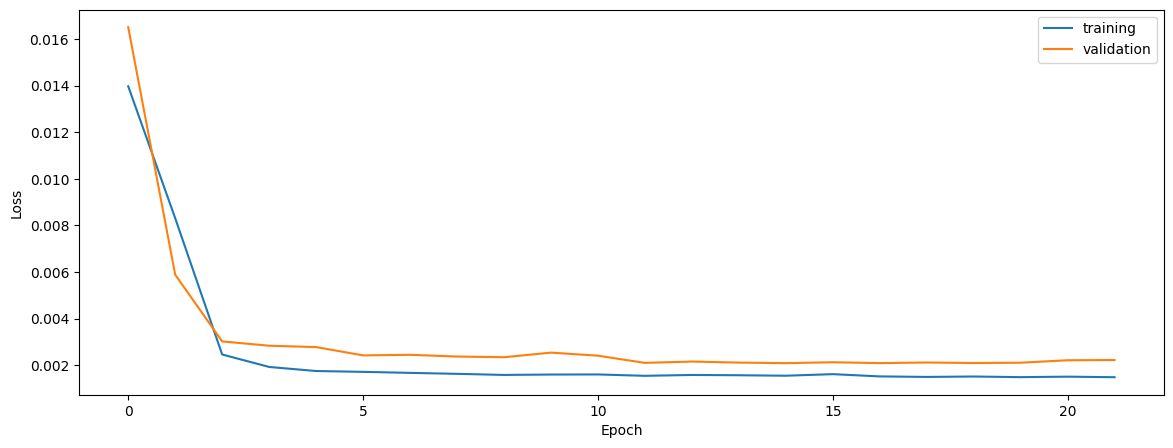

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9390383034026765
0.9357768702157512
0.9369832441156383


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.9390383034026765
0.9357768702157512
0.9369832441156383


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.945574239759668
0.9394195865158882
0.950076484992441


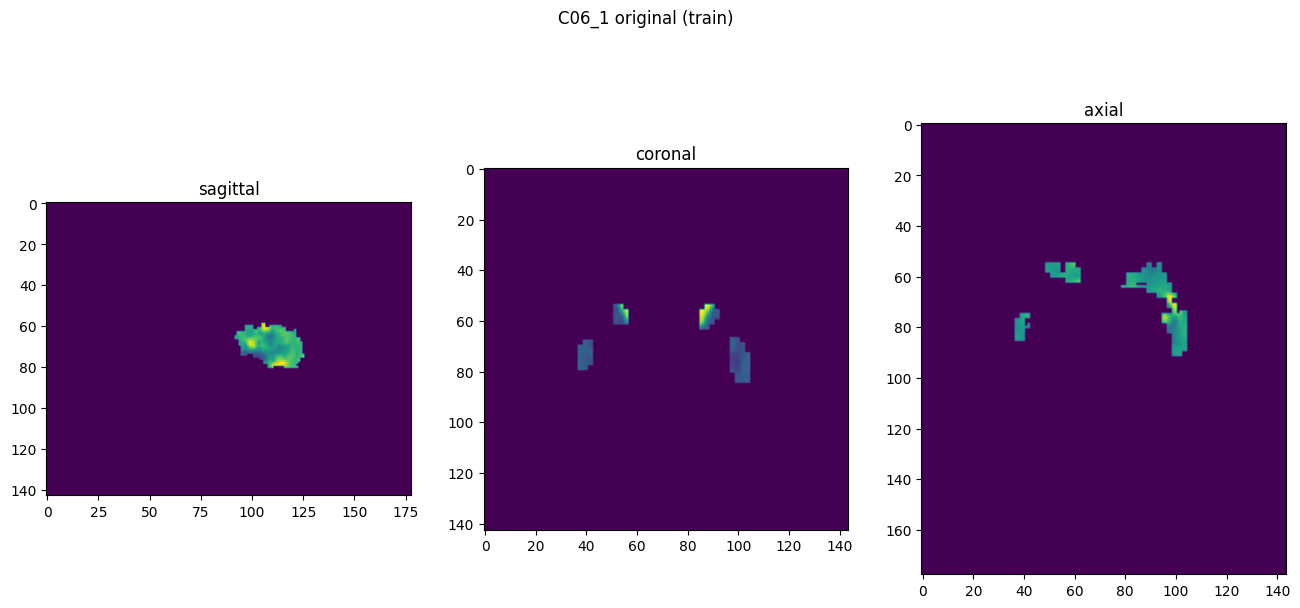

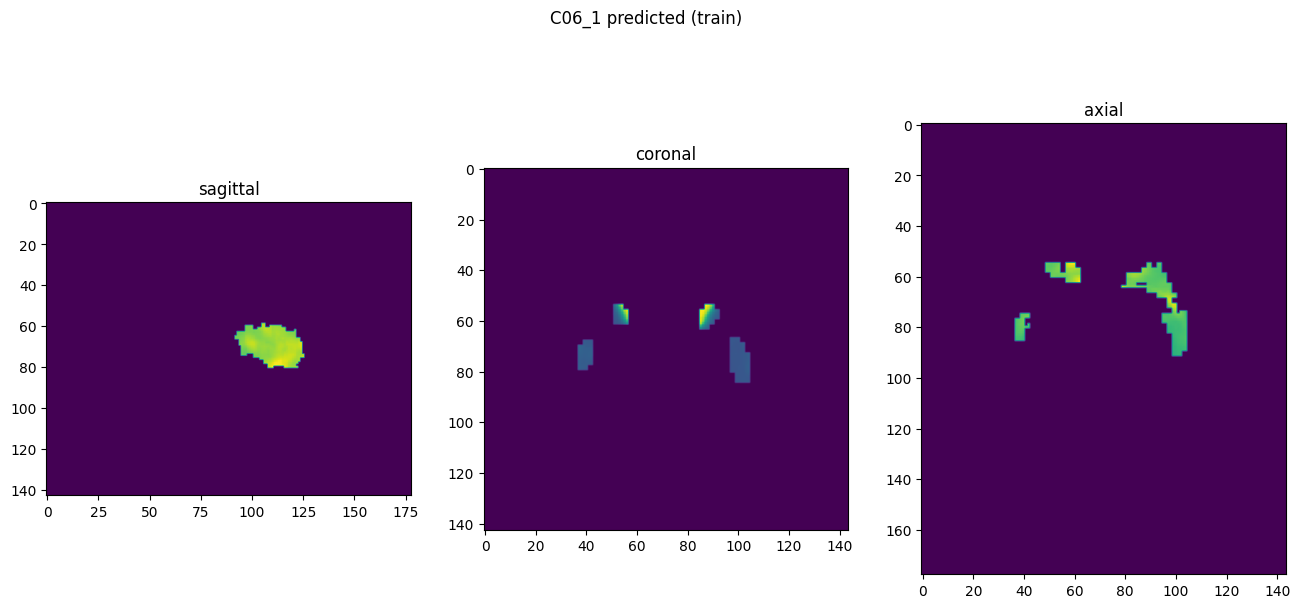

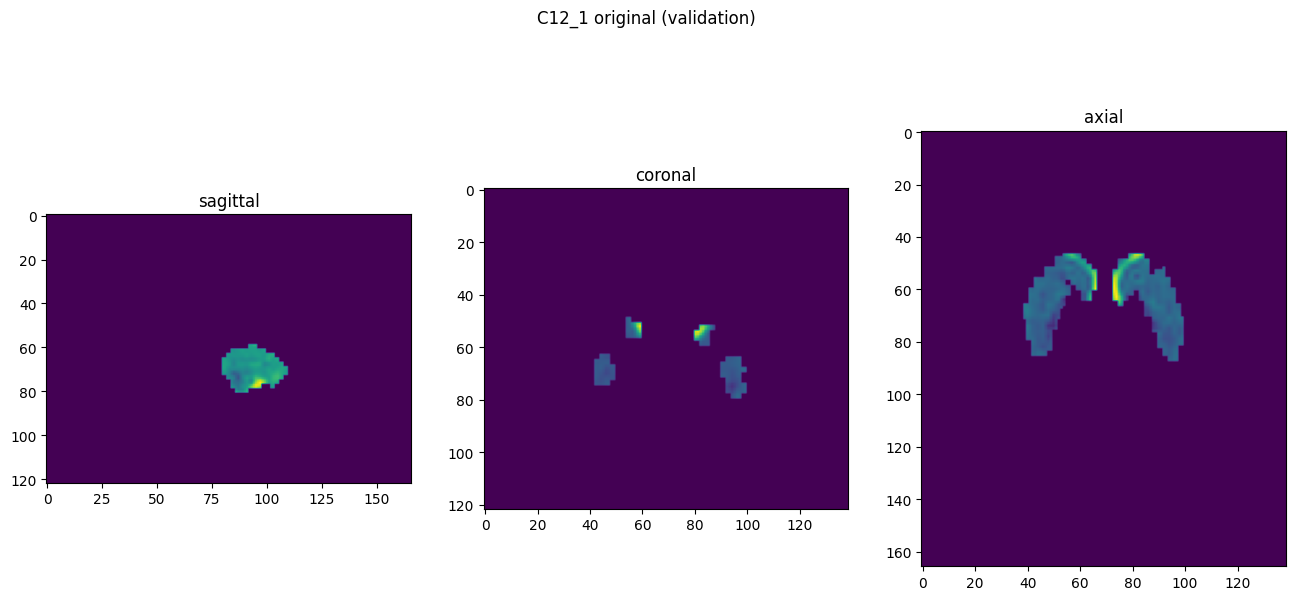

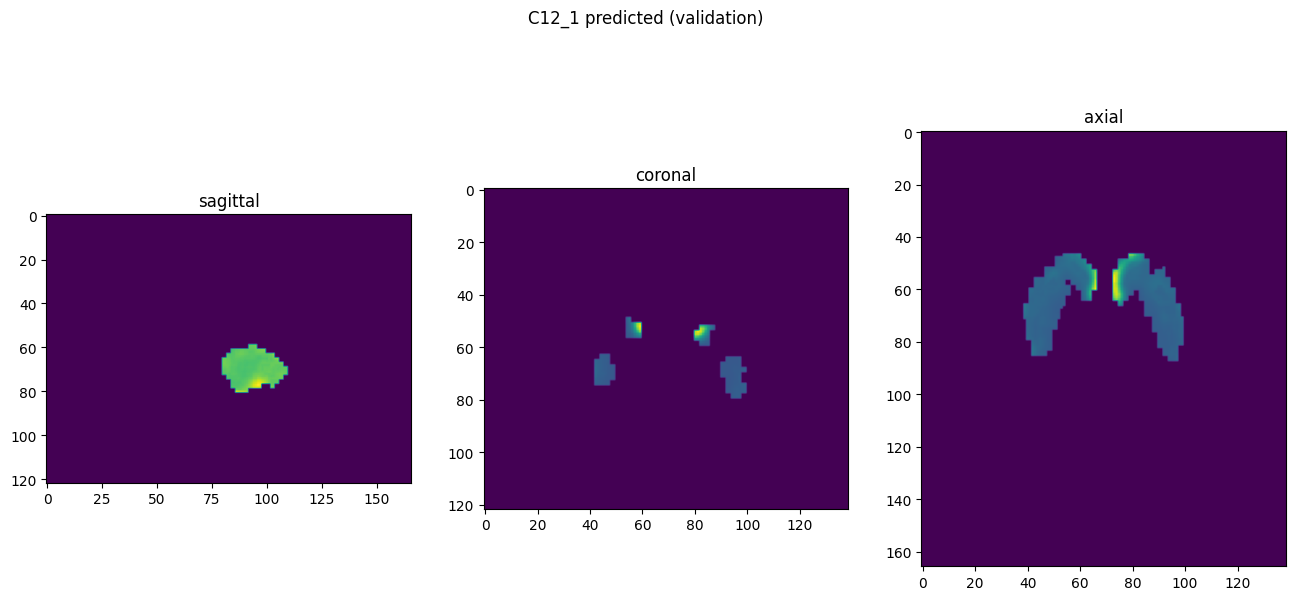

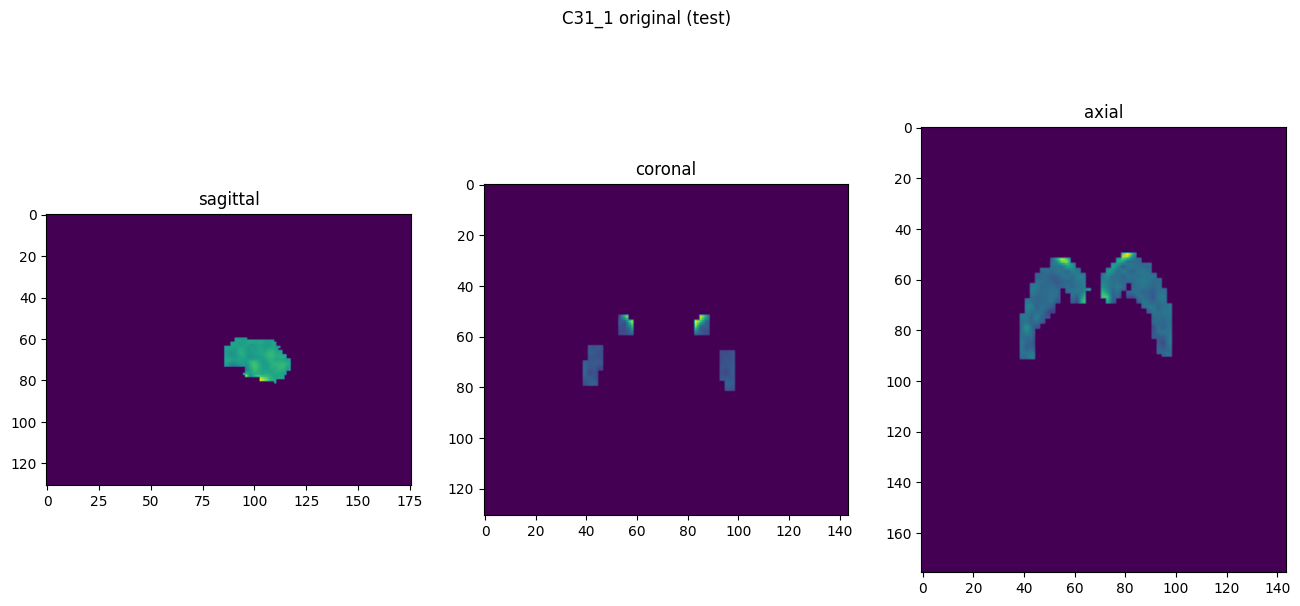

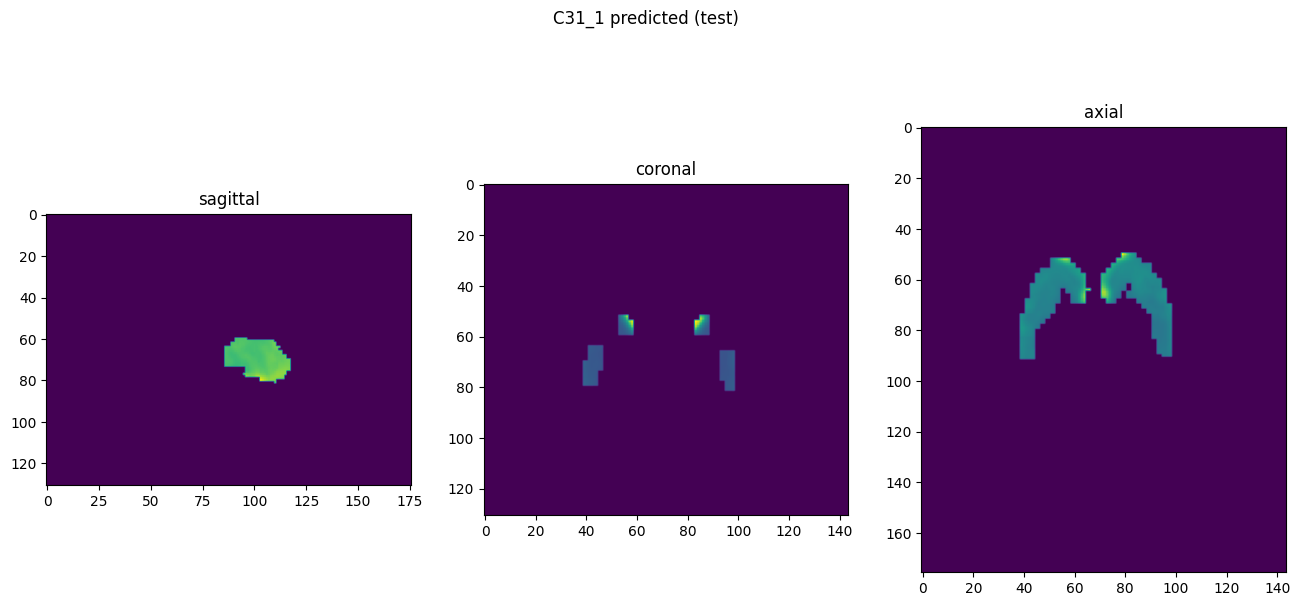

In [10]:
showResults(model, gen, threshold=None, background=False)